In [1255]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from glob import glob

from sklearn.metrics import r2_score
from scipy import stats

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

# load inpainting data from the inpainting notebook(s)

In [1256]:
# debug_0_5000_1_1e-1_c , Same inpainting settings as ExoGAN

general_name = 'debug_0_5000_1_1e-1_wgan' # general filename, e.g. 'test' for test_reals.npy, test_inpainteds.npy... etc.

# get the file paths of the result files
reals = glob('gan_data//val_errors//'+general_name+'_reals.npy')
inpainteds = glob('gan_data//val_errors//'+general_name+'_inpainteds.npy')
n_iterations = glob('gan_data//val_errors//'+general_name+'_n_iterations.npy')


contextuals = glob('gan_data//val_errors//'+general_name+'_contextual_losses.npy')
perceptuals = glob('gan_data//val_errors//'+general_name+'_perceptual_losses.npy')

reals

['gan_data//val_errors//debug_0_5000_1_1e-1_wgan_reals.npy']

In [1257]:
# load arrays to list, convert list to ndarray with shape (aspa, n_inpaintings, height, width)
reals = np.concatenate([np.load(path) for path in reals], axis=0)
inpainteds = np.concatenate([np.load(path) for path in inpainteds], axis=0)

perceptuals = np.concatenate([np.load(path) for path in perceptuals], axis=0)
contextuals = np.concatenate([np.load(path) for path in contextuals], axis=0)

# take mean of the n_inpaintings per aspa
n_aspas = reals.shape[0]
reals = reals.mean(axis=1).reshape(n_aspas,1,32,32)
inpainteds = inpainteds.mean(axis=1).reshape(n_aspas,1,32,32)

In [1258]:
reals.shape

(1061, 1, 32, 32)

In [1259]:
reals.mean(1).shape

(1061, 32, 32)

# Error of ASPA $i$

In [1260]:
"""
3739 is bad with errors: -20.025595	-59.902499	831.523538	-28.148670	22.250920	0.759872	-8.532101 (831% is CO)
4788 is good with errors: 4.121214	0.958426	0.045486	0.866588	-5.077431	-0.756804	2.978271
4998 is 'decent' with errors: 5.578141	7.753601	-6.975316	5.797133	39.391482	-1.526314	-41.867831
"""
i = 0 

decodeds =[ke.decode_params_from_aspa(inpainteds[i, j]) for j in range(reals.shape[1])]

df = pd.DataFrame.from_dict(decodeds)
df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

df.describe()

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
count,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000
mean,-2.445471,-1.745903,-8.103175,-7.900943,3.507513e+27,7.780149e+07,1067.525983,-0.253599,10.328873
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-2.445471,-1.745903,-8.103175,-7.900943,3.507513e+27,7.780149e+07,1067.525983,-0.253599,10.328873
25%,-2.445471,-1.745903,-8.103175,-7.900943,3.507513e+27,7.780149e+07,1067.525983,-0.253599,10.328873
50%,-2.445471,-1.745903,-8.103175,-7.900943,3.507513e+27,7.780149e+07,1067.525983,-0.253599,10.328873
75%,-2.445471,-1.745903,-8.103175,-7.900943,3.507513e+27,7.780149e+07,1067.525983,-0.253599,10.328873
max,-2.445471,-1.745903,-8.103175,-7.900943,3.507513e+27,7.780149e+07,1067.525983,-0.253599,10.328873


In [1261]:
df

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
0,-2.445471,-1.745903,-8.103175,-7.900943,3.507513e+27,7.780149e+07,1067.525983,-0.253599,10.328873


In [1262]:
if reals.shape[1] > 1 :
    params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

    fontsize = 16
    plt.figure(figsize=((25,10)))
    for i,param in enumerate(params):
        plt.subplot(3,3,i+1)
        plt.title(param, fontsize=fontsize)
        plt.hist(df[param], bins=25)

        # plot mean and median line
        mu = df[param].mean()
        plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
        plt.axvline(x=df[param].median(),  color='black', linestyle='-', alpha=1, label='median')

        # plot std lines
        plt.axvline(x=mu-df[param].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
        plt.axvline(x=mu+df[param].std(),  color='black', linestyle=':', alpha=1)

        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.xlabel('Percentage error [%]', fontsize=fontsize)
        plt.ylabel('Counts [-]', fontsize=fontsize)

        plt.legend(fontsize=fontsize)
        plt.grid()
        plt.tight_layout()

In [1263]:
reals.shape

(1061, 1, 32, 32)

In [1264]:
#reals = reals.mean(axis=1) # take the mean of n_inpaintings per aspa, new shape is (aspa, height, width)
#inpainteds = inpainteds.mean(axis=1)

#reals = reals.reshape(reals.shape[0]*reals.shape[1], 32,32)
#inpainteds = inpainteds.reshape(inpainteds.shape[0]*inpainteds.shape[1], 32,32)

#from scipy import stats
#df = df[(np.abs(stats.zscore(df)) < 1).all(axis=1)]

reals.shape

(1061, 1, 32, 32)

In [1265]:
reals.shape

(1061, 1, 32, 32)

## Spectrum plot

In [1266]:
real = reals[i][0]
inpainted = inpainteds[i][0]

real.shape, inpainted.shape

((32, 32), (32, 32))

In [1267]:
real_spec = real[:16, :25].flatten()
inpainted_spec = inpainted[:16, :25].flatten()

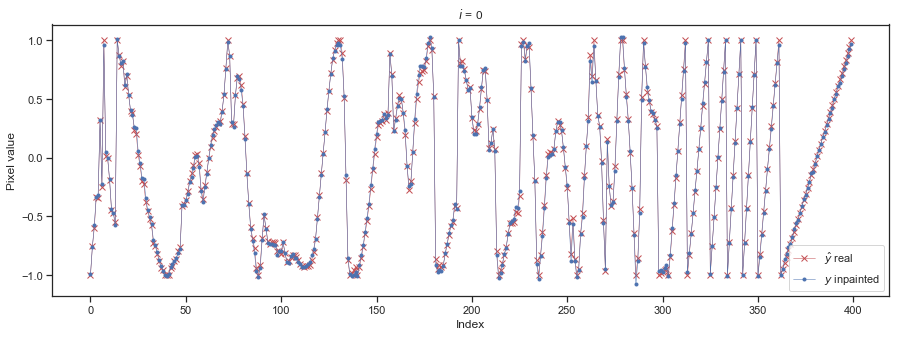

In [1268]:
# :16, :25 is the spectrum location within the ASPA
plt.figure(figsize=(15,5))
plt.plot(real_spec, 'x-', c='r', linewidth=0.5, label=r'$\hat{y}$ real')
plt.plot(inpainted_spec, '.-', linewidth=0.5, label=r'$y$ inpainted')

plt.title(r'$i$ = %s' % i)
plt.xlabel('Index')
plt.ylabel('Pixel value')
plt.legend()

# Pixel difference plot

Text(0, 0.5, '$y$-$\\hat{y}$')

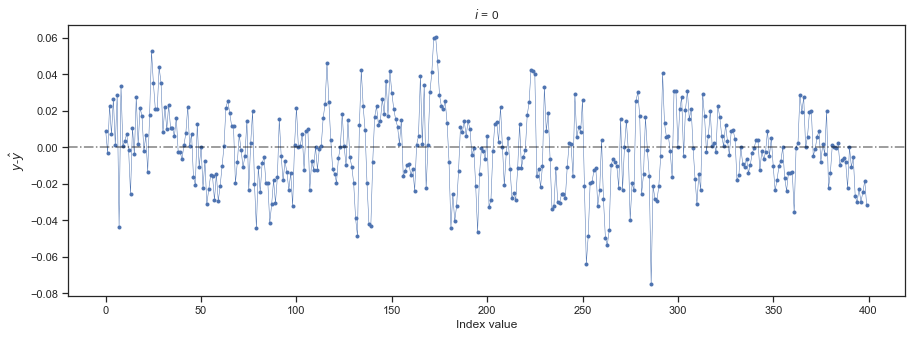

In [1269]:
plt.figure(figsize=(15,5))

plt.plot(inpainted_spec - real_spec, '.-', linewidth=0.5)

plt.axhline(y=0,  color='black', linestyle='-.', alpha=0.5)

plt.title(r'$i$ = %s' % i)
plt.xlabel('Index value')
plt.ylabel(r'$y$-$\hat{y}$')

/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:370: RuntimeWarning: Mean of empty slice.
  mins_ = [aspa[16:17, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:371: RuntimeWarning: Mean of empty slice.
  maxs_ = [aspa[17:18, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


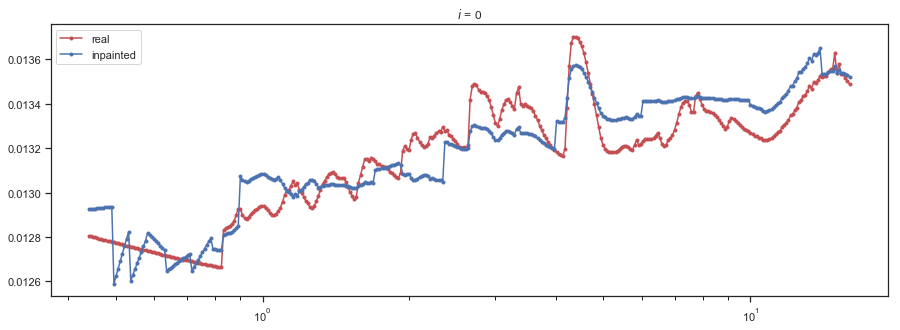

In [1270]:
xhat,yhat = ke.decode_spectrum_from_aspa(real)
x,y  = ke.decode_spectrum_from_aspa(inpainted)

plt.figure(figsize=(15,5))
plt.plot(xhat, yhat, '.-', label='real', c='r')
plt.plot(x,y,'.-', label='inpainted')

plt.gca().set_xscale('log')

plt.title(r'$i$ = %s' % i)
plt.legend()

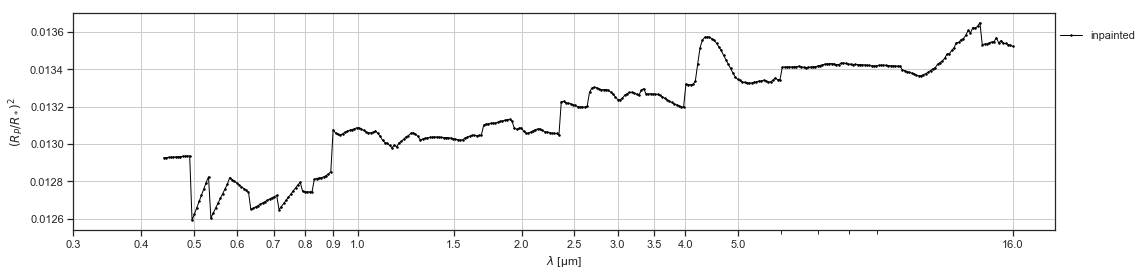

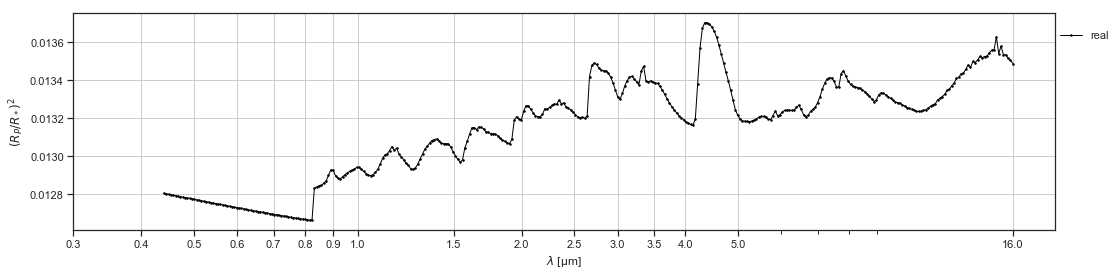

In [1271]:
ke.plot_trans(x,y, label='inpainted')
ke.plot_trans(xhat,yhat, label='real')

# Error of all ASPAs

In [1272]:
reals.shape

(1061, 1, 32, 32)

In [1273]:
reals = [ke.decode_params_from_aspa(real[0]) for real in reals]
inpainteds = [ke.decode_params_from_aspa(inpainted[0]) for inpainted in inpainteds]

In [1274]:
# create dfs for real, inpainted and their percentage errors

reals = pd.DataFrame.from_dict(reals)
inpainteds = pd.DataFrame.from_dict(inpainteds)
errors = (inpainteds - reals) / reals * 100

In [1275]:
contextuals.shape

(1061,)

In [1276]:
errors = errors.replace([np.inf, -np.inf], np.nan) # TODO: Fix the occurance of inf, this has to do with 0 Kelvin values

reals.columns = [column+'_real' for column in reals.columns]
inpainteds.columns = [column+'_inpainted' for column in inpainteds.columns]
errors.columns = [column+'_error' for column in errors.columns]

## Errors df

In [1277]:
errors.describe()

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000
mean,-2.452147,-0.852712,7.725033,4.098608,11.224825,0.049279,-1.459457
std,15.765380,26.322193,91.092124,26.059821,45.587946,1.308879,31.015551
min,-71.714024,-69.958582,-90.741417,-79.630735,-63.296721,-7.920087,-49.632202
25%,-6.889054,-6.312148,-27.691768,-2.501755,-21.451733,-0.758519,-25.346159
50%,-3.245125,-2.839387,-6.713463,1.172536,3.038272,0.092625,-5.787448
75%,-0.373230,1.257481,12.985402,6.634803,34.125296,0.926227,15.429843
max,145.640036,711.525005,730.629539,659.336269,158.696294,4.699885,108.716106


In [1278]:
errors[:10]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
0,-4.307671,-1.792951,1.289687,39.428404,131.000595,0.157824,-3.922661
1,-1.747179,4.194779,-19.642849,25.483016,-43.068730,0.238897,-26.169186
2,-4.514340,3.338583,-38.955753,-1.665634,5.408226,-0.202046,-5.814182
3,-5.656693,-4.042750,9.541548,8.074275,-15.770646,-0.042216,-29.339702
4,-28.605675,-3.747579,-13.844417,-8.383203,31.348364,-0.388163,12.971851
5,-6.819509,-4.630046,-10.132989,-2.563755,7.101054,-0.017525,16.145719
6,8.806360,21.834069,-28.734322,9.841206,14.443544,0.460437,-20.091089
7,-0.418334,1.791801,-24.983536,4.384973,11.267190,0.512220,63.994338
8,-3.342392,-0.832920,-41.050624,4.222179,-2.545446,0.711955,-1.448540
9,-2.344209,-4.567026,-60.896611,1.088815,-38.451727,-0.402540,5.707703


In [1279]:
errors[(errors.co_mixratio_error < 0.1) & (errors.co_mixratio_error > -0.1)]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
584,-7.518535,-8.382848,0.007961,-2.374275,143.653661,2.383109,34.377170
685,-3.172931,-5.111669,-0.098299,4.734136,96.964931,1.026072,34.148091
758,-7.638928,-2.917050,0.095126,-0.901778,-29.557655,-0.080922,-29.736603


In [1280]:
### join the dfs together
df = reals.join(inpainteds, how='outer')
df = df.join(errors, how='outer')

df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

In [1281]:
df.describe()

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
count,1061.000000,1061.000000,1061.000000,1061.000000,1.061000e+03,1.061000e+03,1061.000000,1061.000000,1061.000000,1061.000000,...,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000
mean,-4.355954,-4.441722,-4.489371,-4.594198,2.651595e+27,8.045146e+07,1502.042099,-4.217865,-4.373923,-4.126552,...,1415.243356,-2.452147,-0.852712,7.725033,4.098608,11.224825,0.049279,-1.459457,-0.197083,12.935274
std,2.233978,2.263473,2.274509,2.276846,7.232009e+26,1.561287e+07,317.493896,2.199686,2.277679,2.323976,...,323.355542,15.765380,26.322193,91.092124,26.059821,45.587946,1.308879,31.015551,0.049659,11.066308
min,-8.000000,-8.000000,-8.000000,-8.000000,1.518400e+27,5.592880e+07,1000.000000,-8.294167,-8.604476,-8.534566,...,979.096055,-71.714024,-69.958582,-90.741417,-79.630735,-63.296721,-7.920087,-49.632202,-0.363464,7.852715
25%,-6.444445,-6.444445,-6.444445,-6.444445,2.024533e+27,6.680384e+07,1222.222209,-6.153643,-6.354519,-6.220567,...,1105.801582,-6.889054,-6.312148,-27.691768,-2.501755,-21.451733,-0.758519,-25.346159,-0.230831,10.256859
50%,-4.111111,-4.111111,-4.111111,-4.888889,2.530667e+27,8.311641e+07,1444.444444,-4.072036,-4.201822,-3.685200,...,1345.464662,-3.245125,-2.839387,-6.713463,1.172536,3.038272,0.092625,-5.787448,-0.198677,11.271219
75%,-2.555555,-2.555555,-2.555555,-2.555555,3.289867e+27,9.399146e+07,1777.777791,-2.310001,-2.448663,-2.061760,...,1684.943020,-0.373230,1.257481,12.985402,6.634803,34.125296,0.926227,15.429843,-0.161606,12.690537
max,-1.000000,-1.000000,-1.000000,-1.000000,3.796000e+27,1.048665e+08,2000.000000,-0.687012,-0.557840,-0.740687,...,2087.161064,145.640036,711.525005,730.629539,659.336269,158.696294,4.699885,108.716106,-0.046457,237.478668


In [1282]:
df[:10]

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
0,-2.555555,-1.777778,-8.000000,-5.666667,1.518400e+27,7.767889e+07,1111.111104,-2.445471,-1.745903,-8.103175,...,1067.525983,-4.307671,-1.792951,1.289687,39.428404,131.000595,0.157824,-3.922661,-0.253599,10.328873
1,-2.555555,-1.777778,-2.555555,-6.444445,3.542933e+27,7.224137e+07,2000.000000,-2.510905,-1.852352,-2.053572,...,1476.616289,-1.747179,4.194779,-19.642849,25.483016,-43.068730,0.238897,-26.169186,-0.179149,9.093117
2,-2.555555,-1.777778,-6.444445,-8.000000,2.783733e+27,1.048665e+08,1111.111104,-2.440189,-1.837130,-3.933963,...,1046.509087,-4.514340,3.338583,-38.955753,-1.665634,5.408226,-0.202046,-5.814182,-0.231034,8.254038
3,-3.333333,-6.444445,-2.555555,-7.222222,1.771467e+27,8.311641e+07,1555.555556,-3.144777,-6.183912,-2.799395,...,1099.160194,-5.656693,-4.042750,9.541548,8.074275,-15.770646,-0.042216,-29.339702,-0.200479,10.195154
4,-8.000000,-4.111111,-1.777778,-1.000000,2.783733e+27,6.136632e+07,1000.000000,-5.711546,-3.957044,-1.531655,...,1129.718512,-28.605675,-3.747579,-13.844417,-8.383203,31.348364,-0.388163,12.971851,-0.218153,11.563185
5,-4.111111,-4.888889,-1.777778,-4.888889,3.542933e+27,9.399146e+07,1333.333328,-3.830754,-4.662531,-1.597636,...,1548.609577,-6.819509,-4.630046,-10.132989,-2.563755,7.101054,-0.017525,16.145719,-0.203764,13.093753
6,-1.000000,-1.000000,-1.777778,-1.777778,1.518400e+27,7.767889e+07,1777.777791,-1.088064,-1.218341,-1.266945,...,1420.602880,8.806360,21.834069,-28.734322,9.841206,14.443544,0.460437,-20.091089,-0.219875,10.758988
7,-4.111111,-1.777778,-4.888889,-4.888889,1.771467e+27,7.224137e+07,1222.222209,-4.093913,-1.809632,-3.667472,...,2004.375219,-0.418334,1.791801,-24.983536,4.384973,11.267190,0.512220,63.994338,-0.106005,9.716603
8,-2.555555,-4.111111,-8.000000,-1.777778,2.530667e+27,5.592880e+07,1111.111104,-2.470139,-4.076869,-4.715950,...,1095.016211,-3.342392,-0.832920,-41.050624,4.222179,-2.545446,0.711955,-1.448540,-0.191401,11.805052
9,-4.111111,-1.777778,-7.222222,-6.444445,2.530667e+27,8.311641e+07,1888.888896,-4.014738,-1.696586,-2.824134,...,1996.701062,-2.344209,-4.567026,-60.896611,1.088815,-38.451727,-0.402540,5.707703,-0.173298,9.702034


In [1283]:
#df = df.drop(['temp_profile_error','temp_profile_real','temp_profile_inpainted'], axis=1)

# Percentage error histograms per retrieved parameter

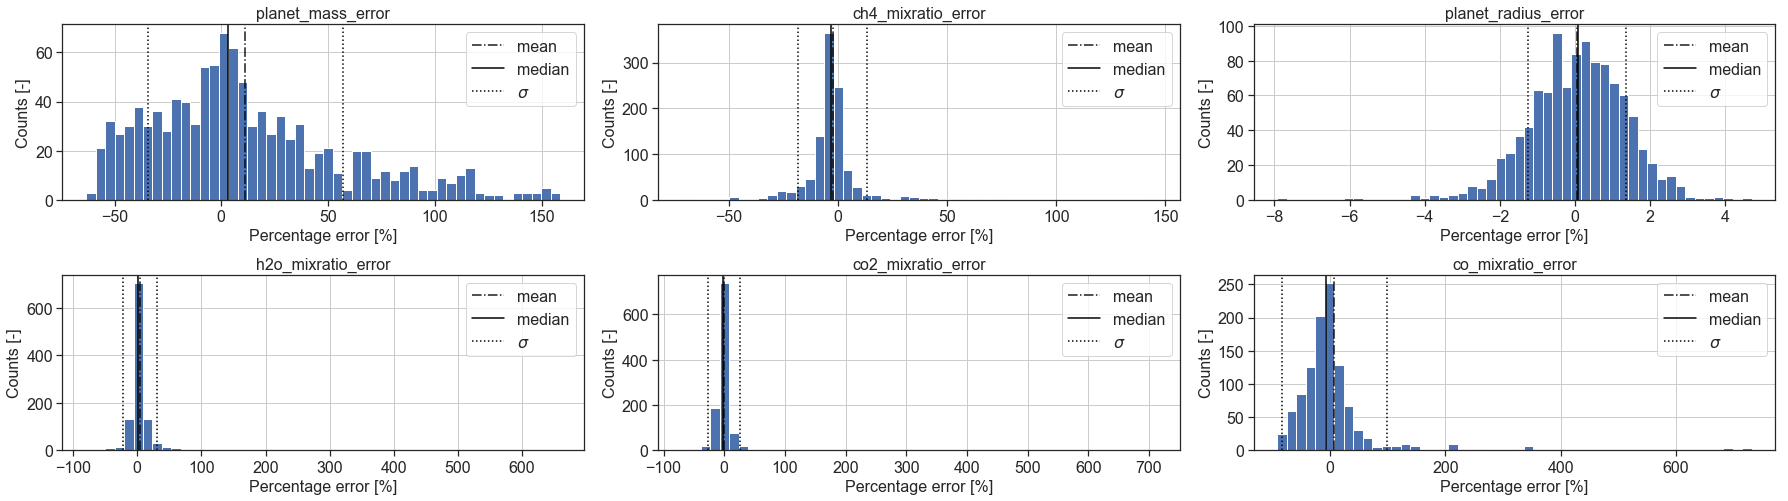

In [1284]:
#params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']
params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

fontsize = 16
plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error', fontsize=fontsize)
    plt.hist(df[param+'_error'], bins=50)
    
    # plot mean and median line
    mu = df[param+'_error'].mean()
    plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
    plt.axvline(x=df[param+'_error'].median(),  color='black', linestyle='-', alpha=1, label='median')

    # plot std lines
    plt.axvline(x=mu-df[param+'_error'].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
    plt.axvline(x=mu+df[param+'_error'].std(),  color='black', linestyle=':', alpha=1)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel('Percentage error [%]', fontsize=fontsize)
    plt.ylabel('Counts [-]', fontsize=fontsize)
    
    plt.legend(fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

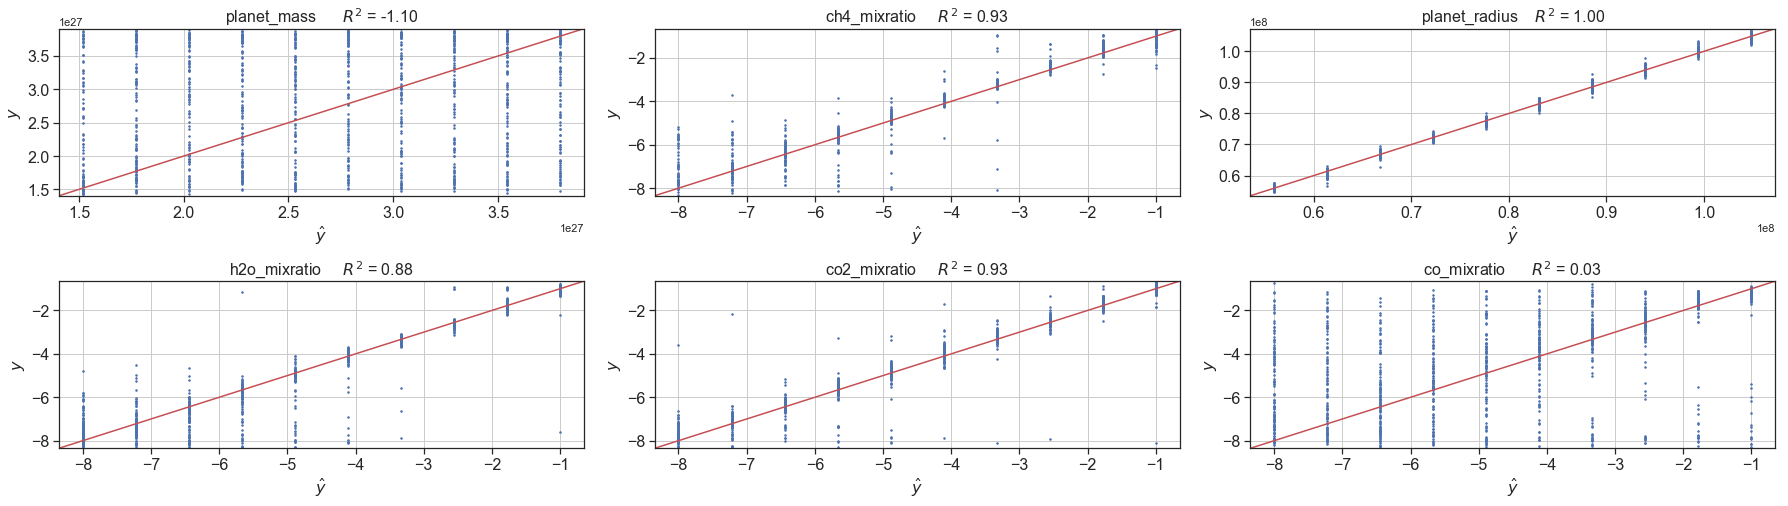

In [1285]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    y_hat = df[param+'_real']
    y = df[param+'_inpainted']
    
    r2 = r2_score(y_hat, y)
    
    plt.subplot(3,3,i+1)

    plt.title(param +' \t $R^2$ = %.2f' % r2, fontsize=fontsize)
    plt.plot(y_hat, y, '.', ms=3)
    
    """Force x,y range on the same scale outliers outside of range wont be plotted!"""
    x_min, x_max = plt.xlim()
    x_min = x_min*1
    x_max = x_max*1
    
    plt.ylim((x_min, x_max)) # set y axis range the same as x axis range
    plt.xlim((x_min, x_max))
    
    # Plot the red 'perfect' prediction line
    plt.plot(plt.xlim(), plt.ylim(), ls="-", c='r')
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel(r"$\hat{y}$", fontsize=fontsize)
    plt.ylabel(r"$y$", fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# 1$\sigma$ percentage error per parameter

### Unique values STD plot
y axis, STD  
X axis, unique values  

This plot shows the STD per parameter value (10 values for ExoGAN data)

Horizontal -. line is the 10% line

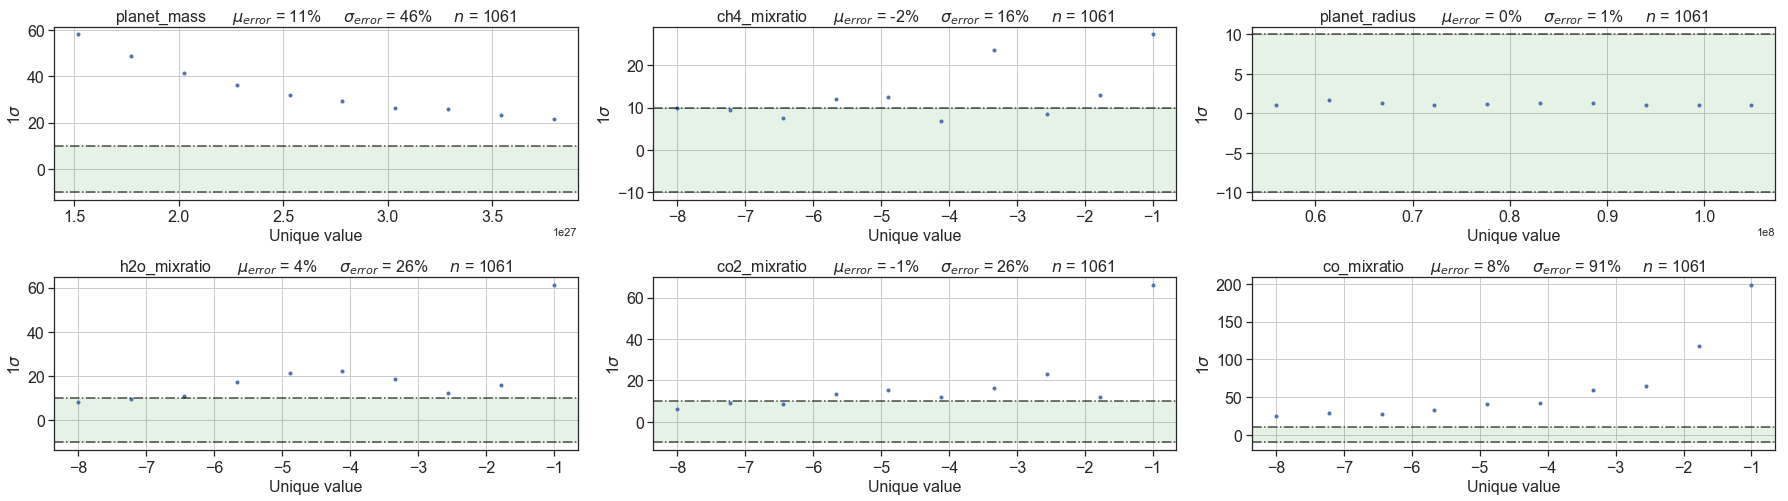

In [1286]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    uniques = df[param+'_real'].unique()
    
    counts = []
    stds = []
    for unique in uniques:
        t = df[param+'_error'][(df[param+'_real'] == unique)]
        std = t.std()
        count = t.count()
        #print(count, std)

        counts.append(count)
        stds.append(std)

    plt.subplot(3,3,i+1)
    plt.plot(uniques, stds, '.')
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Unique value', fontsize=fontsize)
    plt.ylabel(r'1$\sigma$', fontsize=fontsize)
    plt.tight_layout()
    

In [1287]:
iters = [np.load(iters) for iters in n_iterations]
iters

[array([], dtype=float64)]

In [1288]:
uniques

array([-8.        , -2.55555546, -6.44444454, -1.77777773, -4.88888889,
       -7.22222227, -5.6666667 , -3.3333333 , -1.        , -4.11111111])

# Losses

In [1289]:
df[['perceptuals', 'contextuals']].describe()

,perceptuals,contextuals
count,1061.000000,1061.000000
mean,-0.197083,12.935274
std,0.049659,11.066308
min,-0.363464,7.852715
25%,-0.230831,10.256859
50%,-0.198677,11.271219
75%,-0.161606,12.690537
max,-0.046457,237.478668


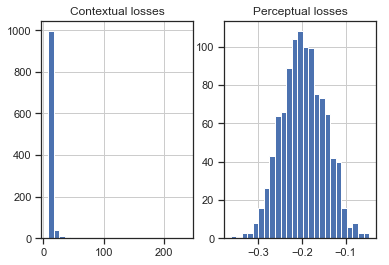

In [1290]:
plt.subplot(1,2,1)
plt.hist(df.contextuals, bins=25)
plt.title('Contextual losses')
plt.grid()

plt.subplot(1,2,2)
plt.hist(df.perceptuals, bins=25)
plt.title('Perceptual losses')
plt.grid()

# Param percentage errors vs contextual loss
For contextual loss, lower is better.

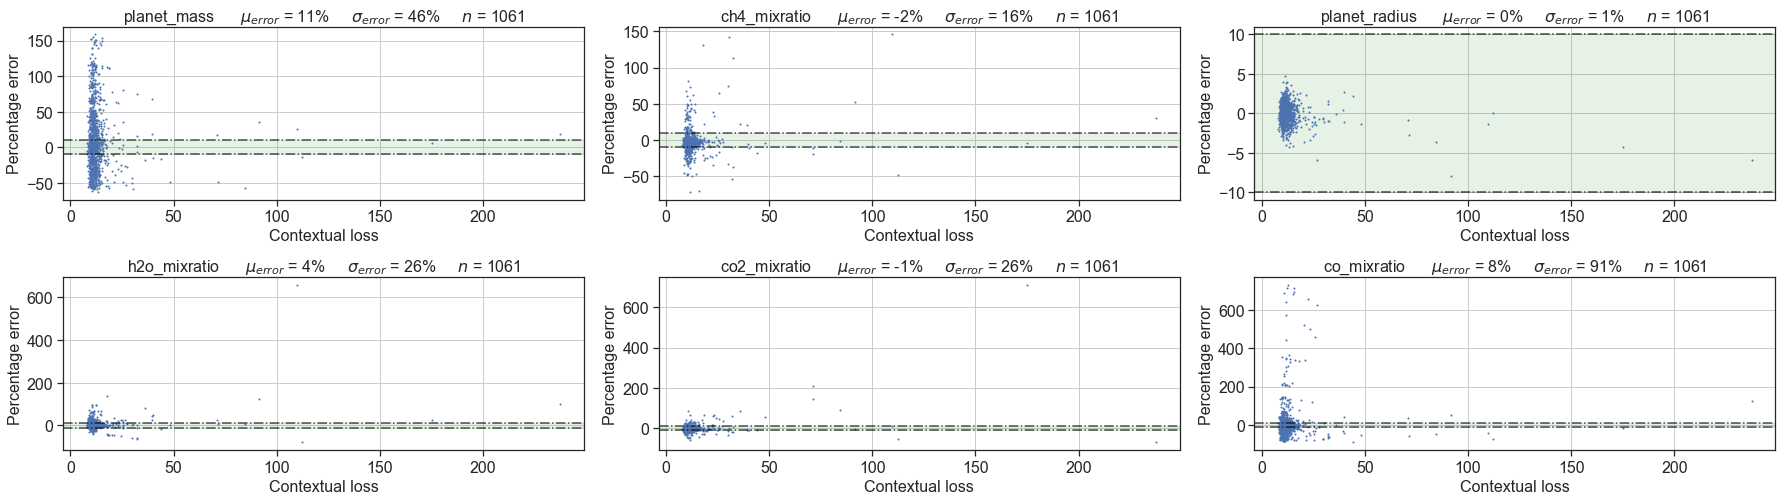

In [1291]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.contextuals, df[param+'_error'], '.', ms=2)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    #plt.ylim((-100,100))
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Contextual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    #plt.legend()
    plt.tight_layout()
    

# Param percentage errors vs perceptual loss
For perceptual loss, lower is better.

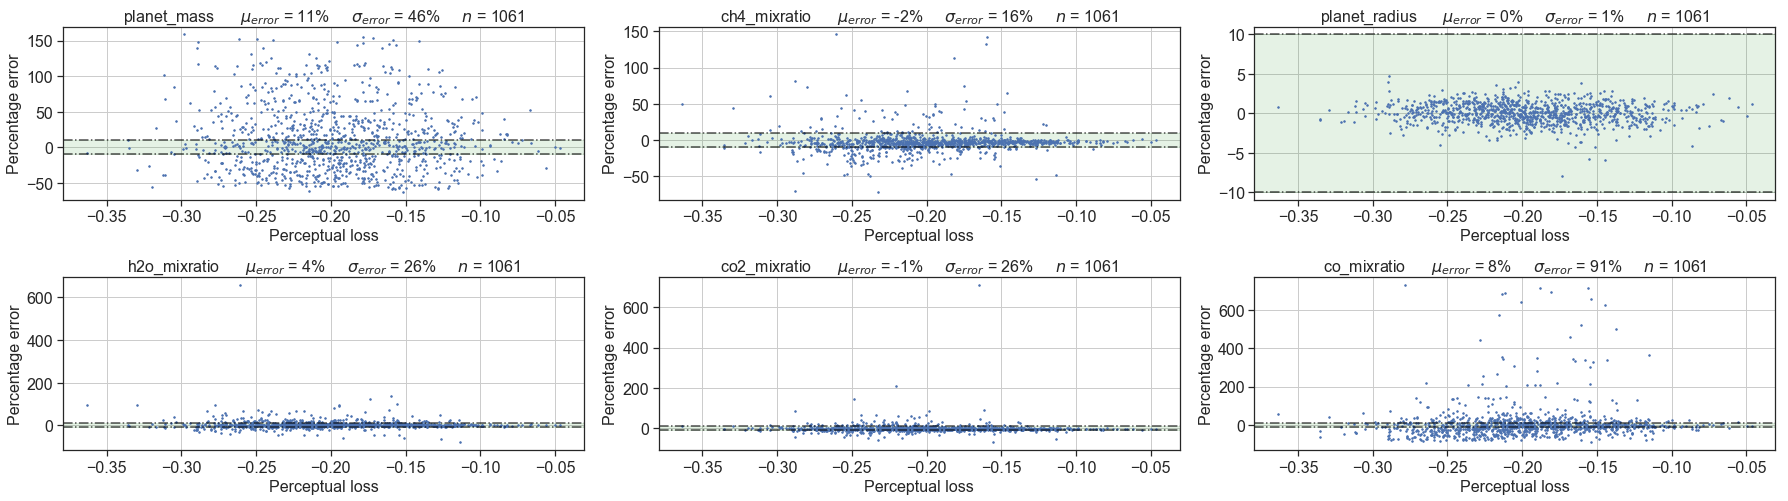

In [1292]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.perceptuals, df[param+'_error'], '.', ms=3)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Perceptual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    plt.tight_layout()